# Cell 1: Data Exploration

Number of training images: 40479
Sample labels:
  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road


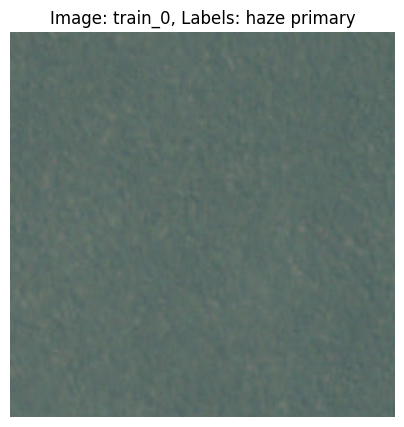

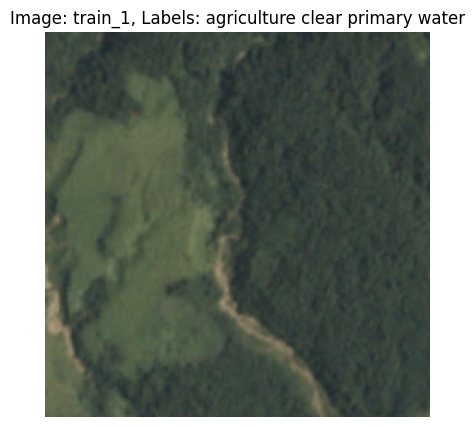

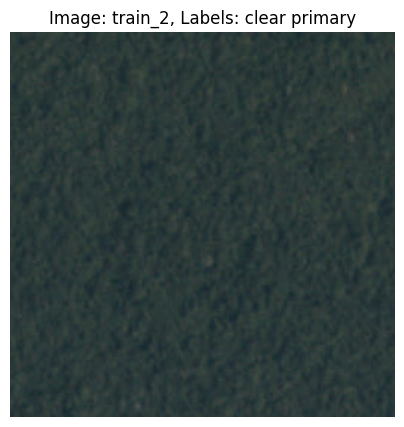

In [1]:
# Cell 1: Data Exploration
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define paths
dataset_path = "/kaggle/input/planets-dataset/planet/planet"
train_csv_path = os.path.join(dataset_path, "train_classes.csv")
train_images_path = os.path.join(dataset_path, "train-jpg")

# Load the training labels
train_df = pd.read_csv(train_csv_path)
print("Number of training images:", len(train_df))
print("Sample labels:")
print(train_df.head())

# Visualize a few sample images
sample_images = train_df['image_name'].iloc[:3].values
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_images_path, f"{img_name}.jpg")
    img = Image.open(img_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Image: {img_name}, Labels: {train_df['tags'].iloc[i]}")
    plt.axis('off')
    plt.show()

# Cell 2: Preprocessing with tf.data.Dataset

Description: We’ll load the image paths and labels, encode the labels using MultiLabelBinarizer, and create a tf.data.Dataset pipeline. We’ll resize images to 224x224 for ResNet50 and apply its preprocessing function. We’ll use the full dataset with a batch size of 16 to manage memory.

2025-04-23 11:13:54.182876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745406834.209940     535 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745406834.218286     535 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of training images in CSV: 40479
Label classes: ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']
Labels shape: (40479, 17)
Sum of labels for each class: [12315   339   862   332    98 28431  2089   100  4477  3660  2697  7261
 37513  8071   340   209  7411]


I0000 00:00:1745406838.003445     535 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745406838.004149     535 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training dataset size: 32383 images, 2023 batches
Validation dataset size: 8096 images, 506 batches
Batch shape: (16, 224, 224, 3)
Labels shape: (16, 17)
Image 0 - Min pixel value: 0.11619067192077637, Max pixel value: 0.737858772277832
Displaying preprocessed image 0:


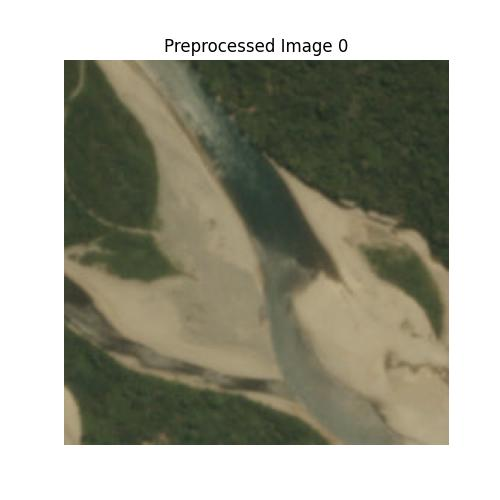

Image 1 - Min pixel value: 0.4186716377735138, Max pixel value: 0.7598639726638794
Displaying preprocessed image 1:


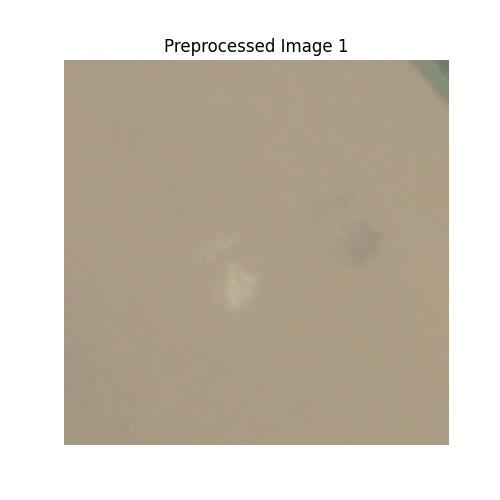

Image 2 - Min pixel value: 0.19109494984149933, Max pixel value: 0.9563663005828857
Displaying preprocessed image 2:


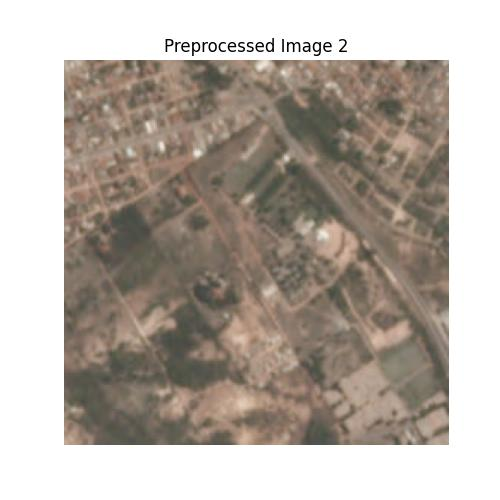

In [2]:
# Cell 2: Preprocessing with tf.data.Dataset
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

# Define paths
dataset_path = "/kaggle/input/planets-dataset/planet/planet"
train_csv_path = os.path.join(dataset_path, "train_classes.csv")
train_images_path = os.path.join(dataset_path, "train-jpg")
test_images_path = os.path.join(dataset_path, "test-jpg")

# Load the training labels
train_df = pd.read_csv(train_csv_path)
print("Number of training images in CSV:", len(train_df))  # Should be 40479

# Convert tags into a list of labels
train_df['tags'] = train_df['tags'].apply(lambda x: x.split())

# Use MultiLabelBinarizer to encode the tags
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(train_df['tags'])
label_classes = mlb.classes_
print("Label classes:", label_classes)
print("Labels shape:", labels.shape)  # Should be (40479, 17)
print("Sum of labels for each class:", np.sum(labels, axis=0))  # Should show reasonable frequencies

# Create lists of image paths and corresponding labels
image_paths = [os.path.join(train_images_path, f"{img_name}.jpg") for img_name in train_df['image_name']]
labels = np.array(labels, dtype=np.float32)

# Function to load and preprocess a single image using PIL
def load_and_preprocess_image(image_path, label):
    image_path = image_path.numpy().decode('utf-8')
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img, dtype=np.float32) / 255.0
    return img, label

# Wrapper function to make load_and_preprocess_image compatible with tf.data
def tf_load_and_preprocess_image(image_path, label):
    img, label = tf.py_function(load_and_preprocess_image, [image_path, label], [tf.float32, tf.float32])
    img.set_shape([224, 224, 3])
    label.set_shape([len(label_classes)])
    return img, label

# Function for data augmentation (only for training)
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.95, upper=1.05)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# Create a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.shuffle(buffer_size=len(image_paths))

# Split into training and validation sets (80-20 split)
dataset_size = len(image_paths)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Create train and validation datasets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

# Batch the datasets
batch_size = 16
train_dataset = train_dataset.map(tf_load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(tf_load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch
train_steps_per_epoch = train_size // batch_size
val_steps = val_size // batch_size

# Repeat the datasets for multiple epochs
total_epochs = 10  # Reduced to match Cell 4
train_dataset = train_dataset.repeat(total_epochs + 1)
val_dataset = val_dataset.repeat(total_epochs + 1)

# Debug: Verify dataset sizes
train_count = sum(1 for _ in train_dataset.take(train_steps_per_epoch))
val_count = sum(1 for _ in val_dataset.take(val_steps))
print(f"Training dataset size: {train_size} images, {train_count} batches")
print(f"Validation dataset size: {val_size} images, {val_count} batches")

# Debug: Visualize a few preprocessed images from the train_dataset
for images, labels_batch in train_dataset.take(1):
    print("Batch shape:", images.shape)
    print("Labels shape:", labels_batch.shape)
    for i in range(min(3, batch_size)):
        img = images[i].numpy()
        print(f"Image {i} - Min pixel value: {img.min()}, Max pixel value: {img.max()}")
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Preprocessed Image {i}")
        plt.axis('off')
        plt.savefig(f"preprocessed_image_{i}.jpg")
        plt.close()
        print(f"Displaying preprocessed image {i}:")
        display(IPImage(filename=f"preprocessed_image_{i}.jpg"))
    break

# Prepare a small test set for change detection (1000 images)
test_image_files = os.listdir(test_images_path)[:1000]
test_image_paths = [os.path.join(test_images_path, img_file) for img_file in test_image_files]
test_dataset = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_dataset = test_dataset.map(lambda x: tf_load_and_preprocess_image(x, tf.zeros(len(label_classes))), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Cell 3: Build and Compile  Pre-Trained ResNet50

In [3]:
# Cell 3: Build and Compile Pre-Trained ResNet50 Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
import tensorflow as tf

# Define custom F1-score metric (sample-wise average, lower threshold)
def f1_score(y_true, y_pred):
    threshold = 0.3  # Lower threshold for sigmoid outputs
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    tp = K.sum(y_true * y_pred, axis=1)  # Sum over labels per sample
    fp = K.sum((1 - y_true) * y_pred, axis=1)
    fn = K.sum(y_true * (1 - y_pred), axis=1)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)  # Average over samples

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_classes), activation='sigmoid')
])

# Compile the model with binary cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # Switch to BCE for stability
              metrics=[f1_score])

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │           8,721 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,645,521 (94.02 MB)

 Trainable params: 1,057,809 (4.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Cell 4: Setup Checkpoints and Training

In [4]:
# Cell 4: Setup Checkpoints, Training, and Fine-Tuning
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights to handle label imbalance
label_sums = np.sum(labels, axis=0)
total_samples = len(labels)

# Debug: Print label sums to identify zero frequencies
print("Label sums (frequency of each label):", label_sums)
print("Label classes:", label_classes)

# Avoid divide by zero and cap weights
epsilon = 1e-6
class_weights = total_samples / (len(label_classes) * (label_sums + epsilon))
max_weight = 100.0
class_weights = np.minimum(class_weights, max_weight)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Debug: Print class weights to verify
print("Class weights:", class_weight_dict)

# Define checkpoint and early stopping callbacks
checkpoint_path = "/kaggle/working/best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_f1_score', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_f1_score', patience=5, mode='max', verbose=1)

# Confirm GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Initial training for 15 epochs
print("Training ResNet50 Model (Initial Phase)")
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps_per_epoch,
    epochs=15,  # Increased to 15 epochs
    validation_data=val_dataset,
    validation_steps=val_steps,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Fine-tuning: Unfreeze the last 20 layers of ResNet50
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with a very low learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=[f1_score])

# Fine-tune for 5 more epochs
print("Fine-Tuning ResNet50 Model")
history_fine = model.fit(
    train_dataset,
    steps_per_epoch=train_steps_per_epoch,
    epochs=5,
    validation_data=val_dataset,
    validation_steps=val_steps,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Label sums (frequency of each label): [12315.   339.   862.   332.    98. 28431.  2089.   100.  4477.  3660.
  2697.  7261. 37513.  8071.   340.   209.  7411.]
Label classes: ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']
Class weights: {0: 0.193351, 1: 7.023946, 2: 2.7623174, 3: 7.172041, 4: 24.29712, 5: 0.083750755, 6: 1.1398361, 7: 23.811176, 8: 0.53185564, 9: 0.6505786, 10: 0.8828764, 11: 0.32793248, 12: 0.06347447, 13: 0.29502138, 14: 7.0032873, 15: 11.392907, 16: 0.32129505}
Num GPUs Available:  2
Training ResNet50 Model (Initial Phase)
Epoch 1/15


I0000 00:00:1745406942.437966     586 service.cc:148] XLA service 0x7b997c003780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745406942.438012     586 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745406942.438018     586 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745406943.877716     586 cuda_dnn.cc:529] Loaded cuDNN version 90300


   4/2023 ━━━━━━━━━━━━━━━━━━━━ 1:35 47ms/step - f1_score: 0.2383 - loss: 0.2595 

I0000 00:00:1745406947.911355     586 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2023/2023 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - f1_score: 0.5684 - loss: 0.1754
Epoch 1: val_f1_score improved from -inf to 0.68601, saving model to /kaggle/working/best_model.keras
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 194s 88ms/step - f1_score: 0.5684 - loss: 0.1754 - val_f1_score: 0.6860 - val_loss: 0.2965
Epoch 2/15
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - f1_score: 0.6500 - loss: 0.1515
Epoch 2: val_f1_score improved from 0.68601 to 0.68764, saving model to /kaggle/working/best_model.keras
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 178s 86ms/step - f1_score: 0.6500 - loss: 0.1515 - val_f1_score: 0.6876 - val_loss: 0.2913
Epoch 3/15
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - f1_score: 0.6664 - loss: 0.1531
Epoch 3: val_f1_score did not improve from 0.68764
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 172s 85ms/step - f1_score: 0.6664 - loss: 0.1531 - val_f1_score: 0.6813 - val_loss: 0.3011
Epoch 4/15
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - f1_score: 0.6678 - loss: 0.1594
Epoch 4: val_f1_score improved 

# Fine Tuning 

In [33]:
# # Cell 4.1: Fine-Tune with Focal Loss for Rare Labels (Revised Again)
# import tensorflow.keras.backend as K
# import tensorflow as tf
# from tensorflow.keras.saving import register_keras_serializable

# # Define the focal loss function with serialization support
# @register_keras_serializable()
# def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
#     y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
#     pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#     pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#     return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

# # Wrapper function to pass gamma and alpha parameters
# @register_keras_serializable()
# def focal_loss(gamma=2.0, alpha=0.25):
#     def loss(y_true, y_pred):
#         return focal_loss_fixed(y_true, y_pred, gamma=gamma, alpha=alpha)
#     return loss

# # Increase weights for rare labels
# rare_labels = ['slash_burn', 'selective_logging']
# for label in rare_labels:
#     idx = np.where(label_classes == label)[0][0]
#     class_weight_dict[idx] *= 3  # Triple the weight for slash_burn and selective_logging

# # Recompile with focal loss
# best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#                    loss=focal_loss(),
#                    metrics=[f1_score])

# # Fine-tune for 3 more epochs
# print("Fine-Tuning with Focal Loss for Rare Labels")
# history_fine_2 = best_model.fit(
#     train_dataset,
#     steps_per_epoch=train_steps_per_epoch,
#     epochs=3,
#     validation_data=val_dataset,
#     validation_steps=val_steps,
#     class_weight=class_weight_dict,
#     callbacks=[checkpoint, early_stopping],
#     verbose=1
# )

# Cell 4.1: Fine-Tune Again with Lower Learning Rate
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable

# Define the focal loss function with serialization support
@register_keras_serializable()
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

@register_keras_serializable()
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        return focal_loss_fixed(y_true, y_pred, gamma=gamma, alpha=alpha)
    return loss

# Define F1-score metric (same as in Cell 3)
def f1_score(y_true, y_pred):
    threshold = 0.3
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    tp = K.sum(y_true * y_pred, axis=1)
    fp = K.sum((1 - y_true) * y_pred, axis=1)
    fn = K.sum(y_true * (1 - y_pred), axis=1)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)

# Compile the model with a lower learning rate
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                   loss=focal_loss(),
                   metrics=[f1_score])

# Fine-tune for 2 more epochs
print("Fine-Tuning with Lower Learning Rate")
history_fine_3 = best_model.fit(
    train_dataset,
    steps_per_epoch=train_steps_per_epoch,
    epochs=2,
    validation_data=val_dataset,
    validation_steps=val_steps,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Fine-Tuning with Lower Learning Rate
Epoch 1/2
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - f1_score: 0.7360 - loss: 0.0100
Epoch 1: val_f1_score improved from 0.77317 to 0.78007, saving model to /kaggle/working/best_model.keras
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 243s 110ms/step - f1_score: 0.7360 - loss: 0.0100 - val_f1_score: 0.7801 - val_loss: 0.0192
Epoch 2/2
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - f1_score: 0.7471 - loss: 0.0092
Epoch 2: val_f1_score did not improve from 0.78007
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 220s 106ms/step - f1_score: 0.7471 - loss: 0.0092 - val_f1_score: 0.7764 - val_loss: 0.0190


# Cell 5: Evaluate the Model

In [37]:
# # Cell 5: Evaluate the Model
# from tensorflow.keras.models import load_model
# import tensorflow.keras.backend as K

# # Define F1-score metric (same as in Cell 3)
# def f1_score(y_true, y_pred):
#     threshold = 0.3
#     y_pred = tf.cast(y_pred > threshold, tf.float32)
#     tp = K.sum(y_true * y_pred, axis=1)
#     fp = K.sum((1 - y_true) * y_pred, axis=1)
#     fn = K.sum(y_true * (1 - y_pred), axis=1)
#     precision = tp / (tp + fp + K.epsilon())
#     recall = tp / (tp + fn + K.epsilon())
#     f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
#     return K.mean(f1)

# # Load the best model
# best_model = load_model('/kaggle/working/best_model.keras', custom_objects={'f1_score': f1_score})

# # Evaluate on validation set
# print("Evaluating on validation set:")
# val_loss, val_f1_score = best_model.evaluate(val_dataset, steps=val_steps, verbose=1)
# print(f"Validation Loss: {val_loss:.4f}, Validation F1-Score: {val_f1_score:.4f}")


# Cell 5: Evaluate the Model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import tensorflow as tf

# Define F1-score metric (same as in Cell 3)
def f1_score(y_true, y_pred):
    threshold = 0.3
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    tp = K.sum(y_true * y_pred, axis=1)
    fp = K.sum((1 - y_true) * y_pred, axis=1)
    fn = K.sum(y_true * (1 - y_pred), axis=1)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)

# Define focal loss (simplified to avoid nested function)
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

# Load the best model with both custom objects
best_model = load_model('/kaggle/working/best_model.keras', custom_objects={'f1_score': f1_score, 'focal_loss': focal_loss})

# Evaluate on validation set
print("Evaluating on validation set:")
val_loss, val_f1_score = best_model.evaluate(val_dataset, steps=val_steps, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation F1-Score: {val_f1_score:.4f}")

Evaluating on validation set:
506/506 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - f1_score: 0.7774 - loss: 0.0192
Validation Loss: 0.0192, Validation F1-Score: 0.7784


Displaying F1-Score plot:


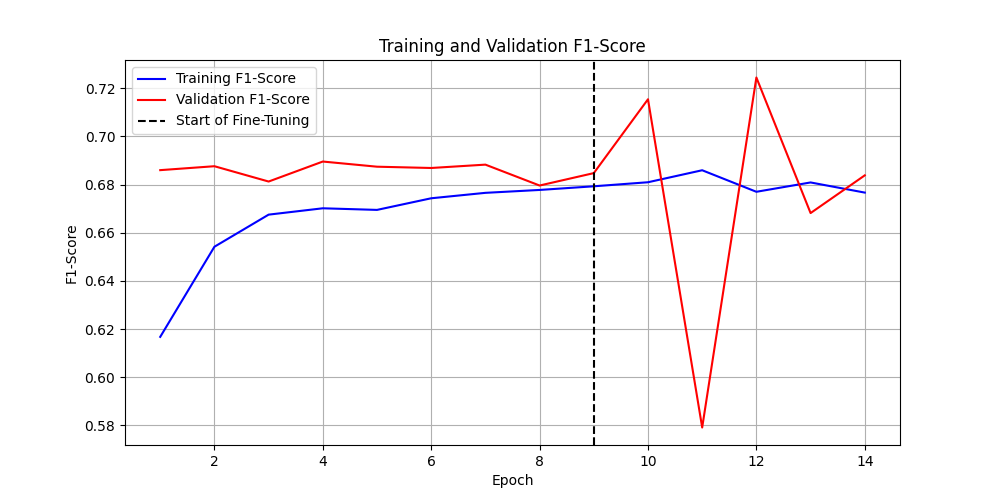

Displaying Loss plot:


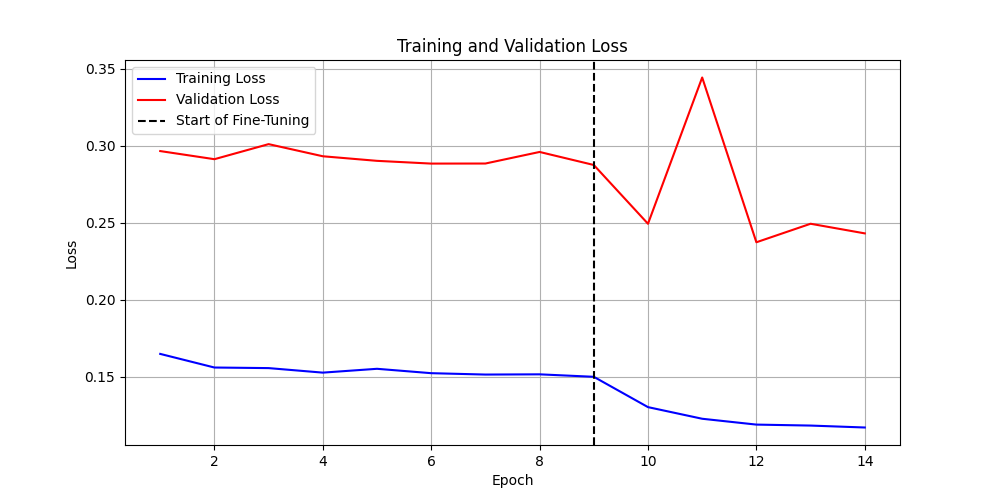

In [38]:
# Cell 5.1: Visualize Training History
import matplotlib.pyplot as plt

# Combine history from initial training and fine-tuning
f1_score = history.history['f1_score'] + history_fine.history['f1_score']
val_f1_score = history.history['val_f1_score'] + history_fine.history['val_f1_score']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
epochs = range(1, len(f1_score) + 1)

# Plot F1-Score
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_score, 'b-', label='Training F1-Score')
plt.plot(epochs, val_f1_score, 'r-', label='Validation F1-Score')
plt.axvline(x=len(history.history['f1_score']), color='k', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.savefig('f1_score_plot.png')
plt.close()
print("Displaying F1-Score plot:")
display(IPImage(filename='f1_score_plot.png'))

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.axvline(x=len(history.history['f1_score']), color='k', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.close()
print("Displaying Loss plot:")
display(IPImage(filename='loss_plot.png'))

# Cell 6: Change Detection

In [65]:
# # Cell 6: Perform Change Detection (Post Fine-Tuning)
# import numpy as np
# from tensorflow.keras.models import load_model
# import tensorflow.keras.backend as K
# import tensorflow as tf

# # Define F1-score metric (same as in Cell 3)
# def f1_score(y_true, y_pred):
#     threshold = 0.3
#     y_pred = tf.cast(y_pred > threshold, tf.float32)
#     tp = K.sum(y_true * y_pred, axis=1)
#     fp = K.sum((1 - y_true) * y_pred, axis=1)
#     fn = K.sum(y_true * (1 - y_pred), axis=1)
#     precision = tp / (tp + fp + K.epsilon())
#     recall = tp / (tp + fn + K.epsilon())
#     f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
#     return K.mean(f1)

# # Define focal loss (same as in Cell 4.1, needed for loading the model)
# from tensorflow.keras.saving import register_keras_serializable

# @register_keras_serializable()
# def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
#     y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
#     pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#     pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#     return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

# @register_keras_serializable()
# def focal_loss(gamma=2.0, alpha=0.25):
#     def loss(y_true, y_pred):
#         return focal_loss_fixed(y_true, y_pred, gamma=gamma, alpha=alpha)
#     return loss

# # Load the best model
# best_model = load_model('/kaggle/working/best_model.keras', custom_objects={'f1_score': f1_score, 'focal_loss': focal_loss})

# # Predict labels for test images
# print("Predicting labels for test images:")
# test_predictions = best_model.predict(test_dataset, steps=len(test_image_paths) // batch_size + 1, verbose=1)

# # Debug: Inspect raw probabilities for slash_burn, selective_logging, and blow_down
# slash_burn_idx = np.where(label_classes == 'slash_burn')[0][0]  # Index 15
# selective_logging_idx = np.where(label_classes == 'selective_logging')[0][0]  # Index 14
# blow_down_idx = np.where(label_classes == 'blow_down')[0][0]  # Index 4

# slash_burn_probs = test_predictions[:, slash_burn_idx]
# selective_logging_probs = test_predictions[:, selective_logging_idx]
# blow_down_probs = test_predictions[:, blow_down_idx]

# print(f"Max probability for slash_burn: {np.max(slash_burn_probs):.4f}")
# print(f"Max probability for selective_logging: {np.max(selective_logging_probs):.4f}")
# print(f"Max probability for blow_down: {np.max(blow_down_probs):.4f}")

# # Apply different thresholds
# default_threshold = 0.3
# slash_burn_threshold = 0.10  # Increased to reduce false positives
# selective_logging_threshold = 0.10  # Increased to reduce false positives
# blow_down_threshold = 0.13

# # Create binary predictions
# binary_predictions = np.zeros_like(test_predictions, dtype=np.int32)
# binary_predictions = (test_predictions > default_threshold).astype(np.int32)

# # Override thresholds for rare labels
# binary_predictions[:, slash_burn_idx] = (slash_burn_probs > slash_burn_threshold).astype(np.int32)
# binary_predictions[:, selective_logging_idx] = (selective_logging_probs > selective_logging_threshold).astype(np.int32)
# binary_predictions[:, blow_down_idx] = (blow_down_probs > blow_down_threshold).astype(np.int32)

# # Map predictions back to labels
# predicted_labels = []
# for pred in binary_predictions:
#     labels = [label_classes[i] for i, val in enumerate(pred) if val == 1]
#     predicted_labels.append(labels)

# # Detect deforestation
# deforestation_indices = []
# for i, labels in enumerate(predicted_labels):
#     if 'slash_burn' in labels or 'selective_logging' in labels or 'blow_down' in labels:
#         deforestation_indices.append(i)

# print(f"Found {len(deforestation_indices)} images with potential deforestation:")
# print("Indices:", deforestation_indices)

# # Debug: Print predicted labels for the first 5 images
# print("\nPredicted labels for the first 5 test images:")
# for i in range(min(5, len(predicted_labels))):
#     print(f"Image {i}: {predicted_labels[i]}")



# Cell 6: Perform Change Detection (Adjusted Thresholds Post-Fine-Tuning)
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import tensorflow as tf

# Define F1-score metric (same as in Cell 3)
def f1_score(y_true, y_pred):
    threshold = 0.3
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    tp = K.sum(y_true * y_pred, axis=1)
    fp = K.sum((1 - y_true) * y_pred, axis=1)
    fn = K.sum(y_true * (1 - y_pred), axis=1)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)

# Define focal loss (simplified version)
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

# Load the best model
best_model = load_model('/kaggle/working/best_model.keras', custom_objects={'f1_score': f1_score, 'focal_loss': focal_loss})

# Predict labels for test images
print("Predicting labels for test images:")
test_predictions = best_model.predict(test_dataset, steps=len(test_image_paths) // batch_size + 1, verbose=1)

# Debug: Inspect raw probabilities for slash_burn, selective_logging, and blow_down
slash_burn_idx = np.where(label_classes == 'slash_burn')[0][0]  # Index 15
selective_logging_idx = np.where(label_classes == 'selective_logging')[0][0]  # Index 14
blow_down_idx = np.where(label_classes == 'blow_down')[0][0]  # Index 4

slash_burn_probs = test_predictions[:, slash_burn_idx]
selective_logging_probs = test_predictions[:, selective_logging_idx]
blow_down_probs = test_predictions[:, blow_down_idx]

print(f"Max probability for slash_burn: {np.max(slash_burn_probs):.4f}")
print(f"Max probability for selective_logging: {np.max(selective_logging_probs):.4f}")
print(f"Max probability for blow_down: {np.max(blow_down_probs):.4f}")

# Apply different thresholds
default_threshold = 0.3
slash_burn_threshold = 0.10  # Adjusted to reduce false positives
selective_logging_threshold = 0.13 # Adjusted to reduce false positives
blow_down_threshold = 0.155  # Adjusted to reduce false positives

# Create binary predictions
binary_predictions = np.zeros_like(test_predictions, dtype=np.int32)
binary_predictions = (test_predictions > default_threshold).astype(np.int32)

# Override thresholds for rare labels
binary_predictions[:, slash_burn_idx] = (slash_burn_probs > slash_burn_threshold).astype(np.int32)
binary_predictions[:, selective_logging_idx] = (selective_logging_probs > selective_logging_threshold).astype(np.int32)
binary_predictions[:, blow_down_idx] = (blow_down_probs > blow_down_threshold).astype(np.int32)

# Map predictions back to labels
predicted_labels = []
for pred in binary_predictions:
    labels = [label_classes[i] for i, val in enumerate(pred) if val == 1]
    predicted_labels.append(labels)

# Detect deforestation
deforestation_indices = []
for i, labels in enumerate(predicted_labels):
    if 'slash_burn' in labels or 'selective_logging' in labels or 'blow_down' in labels:
        deforestation_indices.append(i)

print(f"Found {len(deforestation_indices)} images with potential deforestation:")
print("Indices:", deforestation_indices)

# Debug: Print predicted labels for the first 5 images
print("\nPredicted labels for the first 5 test images:")
for i in range(min(5, len(predicted_labels))):
    print(f"Image {i}: {predicted_labels[i]}")

Predicting labels for test images:
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step
Max probability for slash_burn: 0.1101
Max probability for selective_logging: 0.1332
Max probability for blow_down: 0.1558
Found 30 images with potential deforestation:
Indices: [3, 12, 22, 30, 179, 194, 209, 242, 263, 301, 362, 429, 468, 490, 543, 556, 564, 639, 659, 680, 692, 705, 734, 738, 790, 796, 841, 882, 925, 996]

Predicted labels for the first 5 test images:
Image 0: ['clear', 'primary']
Image 1: ['clear', 'primary']
Image 2: ['agriculture', 'clear', 'partly_cloudy', 'primary', 'road', 'water']
Image 3: ['agriculture', 'clear', 'primary', 'road', 'slash_burn', 'water']
Image 4: ['clear', 'primary']


# Cell 7: Visualize Environmental Changes

Loading image 3 from path: /kaggle/input/planets-dataset/planet/planet/test-jpg/test_24790.jpg
Image 3 shape: (224, 224, 3), min value: 61, max value: 176
After normalization - min value: 0.23921568627450981, max value: 0.6901960784313725
Displaying deforestation image 0:


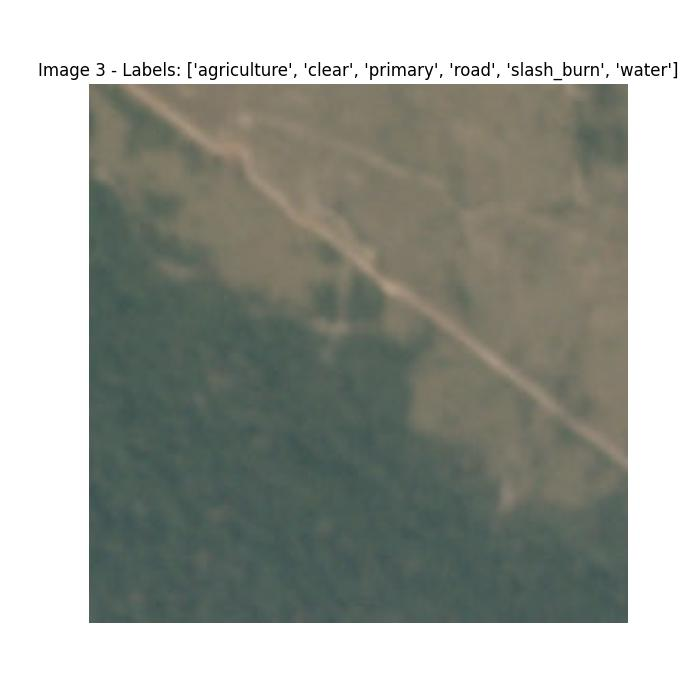

Loading image 12 from path: /kaggle/input/planets-dataset/planet/planet/test-jpg/test_19102.jpg
Image 12 shape: (224, 224, 3), min value: 49, max value: 205
After normalization - min value: 0.19215686274509805, max value: 0.803921568627451
Displaying deforestation image 1:


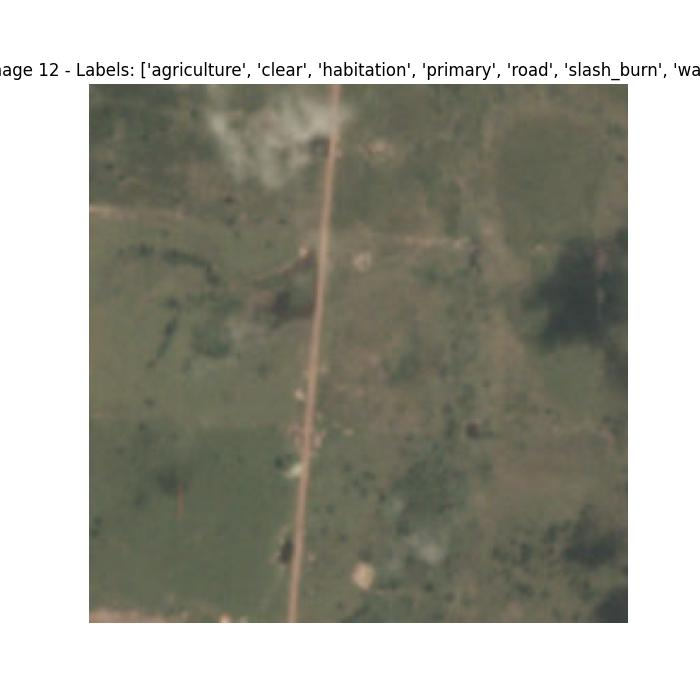

Loading image 22 from path: /kaggle/input/planets-dataset/planet/planet/test-jpg/test_36146.jpg
Image 22 shape: (224, 224, 3), min value: 97, max value: 223
After normalization - min value: 0.3803921568627451, max value: 0.8745098039215686
Displaying deforestation image 2:


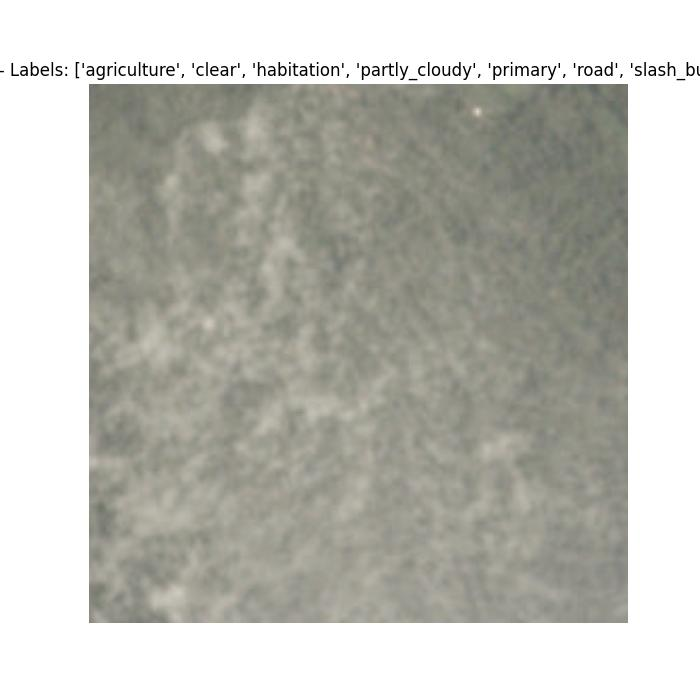

In [66]:
# Cell 7: Visualize Deforestation Results (Debugged)
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Image as IPImage
import numpy as np

# Visualize a few images with deforestation
num_images_to_show = min(3, len(deforestation_indices))
for i, idx in enumerate(deforestation_indices[:num_images_to_show]):
    # Load the raw image from test_image_paths
    img_path = test_image_paths[idx]
    print(f"Loading image {idx} from path: {img_path}")
    
    # Open the image and ensure it's in RGB format
    img = Image.open(img_path).convert('RGB')
    
    # Resize to 224x224
    img = img.resize((224, 224))
    
    # Convert to numpy array
    img = np.array(img)
    print(f"Image {idx} shape: {img.shape}, min value: {img.min()}, max value: {img.max()}")
    
    # Normalize only if the values are in [0, 255]
    if img.max() > 1.0:
        img = img / 255.0
    print(f"After normalization - min value: {img.min()}, max value: {img.max()}")
    
    # Display the image
    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.title(f"Image {idx} - Labels: {predicted_labels[idx]}")
    plt.axis('off')
    plt.savefig(f"deforestation_image_{i}.jpg")
    plt.close()
    print(f"Displaying deforestation image {i}:")
    display(IPImage(filename=f"deforestation_image_{i}.jpg"))

# Cell 8: Save the Model

In [67]:
# Cell 8: Save the Model
model.save("/kaggle/working/final_model.keras")
print("Model saved as 'final_model.keras'")

Model saved as 'final_model.keras'
